Import libraries

In [15]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTEENN
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, \
    StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule, TomekLinks, EditedNearestNeighbours
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, classification_report
def my_boxplot(data, labels, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.boxplot(data)
    ax.set_xticklabels(labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def my_lineplot(x, ylist, yLabelList, xlabel, ylabel, title):
    '''ylist: list of all y'''
    for y,label in zip(ylist,yLabelList):
        plt.plot(x, y, '-o', label=label)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

Prepare the dataset

In [16]:
filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
target = 'stroke'

## 1. Data Exploring

In [17]:
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 1.1. Determine Numerical and Categorical Features

In [18]:
# number of unique values in each column
n_uniques = data.nunique()
# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("CATEGORICAL:", categorical_ix)
print("NUMERICAL  :", numerical_ix)

CATEGORICAL: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
NUMERICAL  : ['age', 'avg_glucose_level', 'bmi']


### 1.2. Visualize the data

In [19]:
variables = [variable for variable in data.columns if variable not in ['id','stroke']]
conts = ['age','avg_glucose_level','bmi']
background_color = "#fafafa"

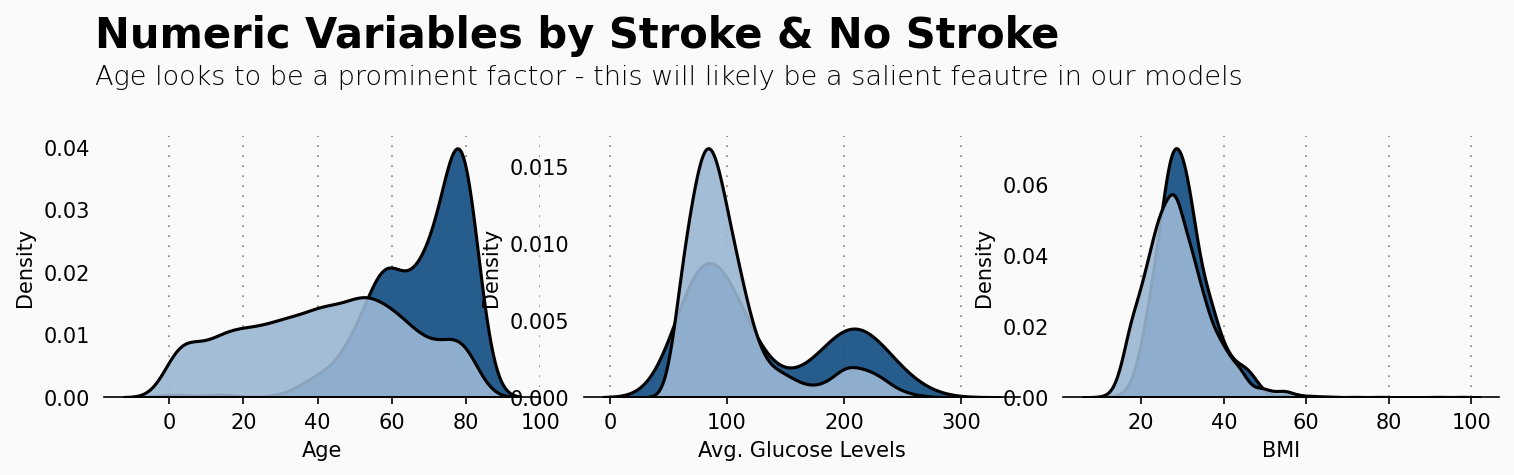

In [20]:
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = data[data['stroke'] == 1]
ns = data[data['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models',
         fontsize=13, fontweight='light')

plt.show()

## 2. Data preprocessing

### 2.1. Handle outlier

In [21]:
data = data[data['gender'] != "Other"]

### 2.2. Handle missing data

In [22]:
for col in data.columns:
    n_miss = data[col].isnull().sum()
    perc = n_miss/data.shape[0] * 100
    print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

> gender                       0            0.0%
> age                          0            0.0%
> hypertension                 0            0.0%
> heart_disease                0            0.0%
> ever_married                 0            0.0%
> work_type                    0            0.0%
> Residence_type               0            0.0%
> avg_glucose_level            0            0.0%
> bmi                        201            3.9%
> smoking_status               0            0.0%
> stroke                       0            0.0%


The dataset had 201 samples with missing BMI value. Instead of
imputing it naively with the mean or the median, we used a simple **decision
tree model** to predict that based on gender and age.

In [23]:
DT_bmi_pipe = Pipeline([('scale',StandardScaler()),
                         ('lr',DecisionTreeRegressor(random_state=42))
                         ])
X = data[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1})
missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
y = X.pop('bmi')
DT_bmi_pipe.fit(X,y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(missing[['age','gender']]),index=missing.index)
data.loc[missing.index,'bmi'] = predicted_bmi
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### 2.3. Split the dataset
Before encoding, we will split the data set

In [24]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'], random_state=42)

Also define our evaluation metric: f1-score and stratified kfold for cross-validation

In [25]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)
scoring = 'f1'

### 2.4. Encode Categorial Features

SVM requires that each data instance is represented as a vector of real numbers.
Hence, if there are categorical attributes, we first have to convert them into numeric
data. For the numerical data, we also have to scale them to the same range. These are some options:

For numerical data:
- Standard Scaler (mean=0, standard deviation=1)
- Min-max Scaler (to the range 0-1)

For categorical data
- Ordinal Encoder (Ordinal type)
- One Hot Encoder (Nominal type)

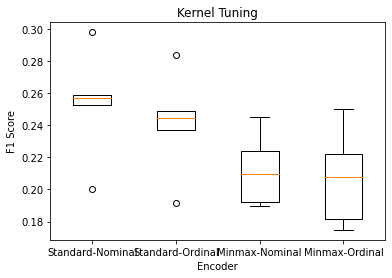

Standard-Nominal mean: 0.253318
Standard-Ordinal mean: 0.241235
Minmax-Nominal mean: 0.212154
Minmax-Ordinal mean: 0.207269


In [26]:
transformers = [('Standard-Nominal', ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                              ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                                             remainder='passthrough')),
               ('Standard-Ordinal', ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                              ('OrdinalEncoder', OrdinalEncoder(),categorical_ix)],
                                             remainder='passthrough')),
               ('Minmax-Nominal', ColumnTransformer([('scale', MinMaxScaler(), numerical_ix),
                                                    ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                                                   remainder='passthrough')),
                ('Minmax-Ordinal', ColumnTransformer([('scale', MinMaxScaler(), numerical_ix),
                                                      ('encode', OrdinalEncoder(), categorical_ix)],
                                                     remainder='passthrough'))
                ]
results = {'Standard-Nominal':[], 'Standard-Ordinal':[], 'Minmax-Nominal':[],'Minmax-Ordinal':[]}
for name, transformer in transformers:
    model = Pipeline([(name, transformer),
                      ('SVC', SVC(class_weight={0:0.1,1:1}))])
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, error_score='raise', n_jobs=-1)
    results[name].extend(cv_results)

my_boxplot(list(results.values()),list(results.keys()),"Encoder", "F1 Score", "Kernel Tuning")
for name in results:
    print('%s mean: %f'%(name,np.array(results[name]).mean()))

The Standard Scaler together with OneHotEncoder give us the highest score. We will choose them as a transformer for the rest of the project.

In [27]:
transformer = ColumnTransformer([('StandardScaler', StandardScaler(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough')

### 2.3. Handle imbalance

First, we will try different option of class weight in SVC and test them on some under-sampling methods like:
- Neighborhood cleaning rule
- Tomek Links
- ENN

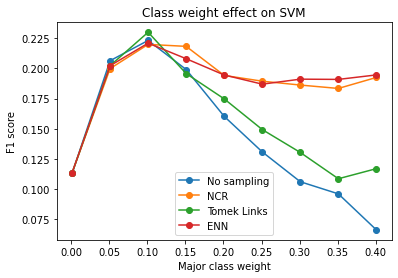

Max score: 0.230067


In [28]:
ratios = np.arange(0.001, 0.41, 0.05)
svc_model = SVC(C=10)

imb_scores = [[]]
under_samplers_scores = [[],[],[]]
under_samplers = [('NCR',NeighbourhoodCleaningRule()),
                  ('Tomek Links',TomekLinks()),
                  ('ENN', EditedNearestNeighbours())
                  ]

for rate in ratios:
    svc_model.set_params(class_weight={0:rate,1:1})
    imb_model = Pipeline([('Trans', transformer), ('SVC', svc_model)])
    imb_results = cross_val_score(imb_model, X_train, y_train, cv=kfold, scoring=scoring,n_jobs=-1)
    imb_scores[0].append(imb_results.mean())
    for sampler, sampler_score in zip(under_samplers,under_samplers_scores):
        sampling_model = Pipeline([('Trans', transformer),
                                   ('Sampler', sampler[1]),
                                   ('SVC', svc_model)
                                   ])
        results = cross_val_score(sampling_model, X_train, y_train, cv=kfold, scoring=scoring,n_jobs=-1)
        sampler_score.append(results.mean())
my_lineplot(x=ratios,
            ylist=imb_scores + under_samplers_scores,
            yLabelList=['No sampling'] + [sampler[0] for sampler in under_samplers],
            xlabel='Major class weight', ylabel='F1 score',title="Class weight effect on SVM")
print("Max score: %f"%(max( max(max(i) for i in under_samplers_scores), max(imb_scores[0]))))

Second, we will compare different sampling method of over-sampling, under-sampling and a combination of those. Our candidates are:
- SMOTE (oversampling)
- Random Oversampling
- Random Undersampling
- SMOTE and Edited Nearest Neighbors (combination of over- and under-)

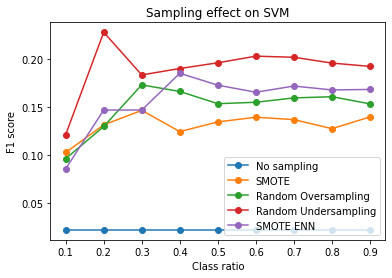

Max score: 0.227509


In [29]:
ratios = np.arange(0.1, 0.91, 0.1)
svc_model = SVC(C=10)
imb_scores = [[]]
samplers_scores = [[],[],[],[]]
samplers = [('SMOTE',SMOTE(random_state=42)),
            ('Random Oversampling',RandomOverSampler(random_state=42)),
            ('Random Undersampling',RandomUnderSampler(random_state=42)),
            ('SMOTE ENN',SMOTEENN(random_state=42))
            ]

for rate in ratios:
    # svc_model.set_params(class_weight={0:rate,1:1}score)
    imb_model = Pipeline([('Trans', transformer), ('SVC', svc_model)])
    imb_results = cross_val_score(imb_model, X_train, y_train, cv=kfold, scoring=scoring,n_jobs=-1)
    imb_scores[0].append(imb_results.mean())
    for sampler, sampler_score in zip(samplers,samplers_scores):
        sampler[1].set_params(sampling_strategy=rate)
        sampling_model = Pipeline([('Trans', transformer),
                                ('Sampler', sampler[1]),
                                ('SVC', svc_model)
                                ])
        results = cross_val_score(sampling_model, X_train, y_train, cv=kfold, scoring=scoring,n_jobs=-1)
        sampler_score.append(results.mean())

# Line plots
my_lineplot(x=ratios,
            ylist=imb_scores + samplers_scores,
            yLabelList=['No sampling'] + [sampler[0] for sampler in samplers],
            xlabel='Class ratio', ylabel='F1 score',title='Sampling effect on SVM')

print("Max score: %f"%(max( max(max(i) for i in samplers_scores), max(imb_scores[0]))))

From 2 experiments, we observe that modifying class weight gave us higher score, so we decided to choose class_weight =0.1 with no sampling method as our main handler for imbalance dataset.
Another reason is that sampling can take lots of computation, and cause information lost

## 3. Enhance the algorithm
Tuning the estimator using Cross-validation and Grid-search

Choosing the best kernel

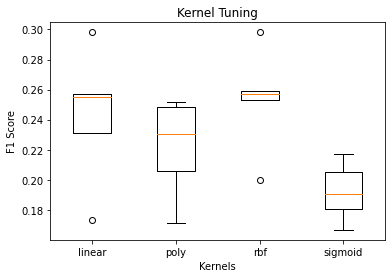

linear mean: 0.242995
poly mean: 0.221695
rbf mean: 0.253318
sigmoid mean: 0.192108


In [30]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {'linear':[], 'poly':[], 'rbf':[], 'sigmoid':[]}
for kernel in results:
    kernel_model = Pipeline([('Trans',transformer),
                             ('SVC',SVC(kernel=kernel,class_weight={0:0.1,1:1}))
                             ])
    cv_results = cross_val_score(kernel_model, X_train, y_train, cv=kfold, scoring=scoring)
    results[kernel].extend(cv_results)
my_boxplot(list(results.values()),kernels,"Kernels", "F1 Score", "Kernel Comparision")
for name in results:
    print('%s mean: %f'%(name,np.array(results[name]).mean()))

Parameter chosen range:
- Kernel: RBF
- C (penalty parameter): $$2^{-2} \to 2^{20}$$
- Gamma (kernel parameter): $$2^{-15} \to 2^{1}$$

the parameters {'SVC__C': 0.25, 'SVC__gamma': 0.125} are the best.


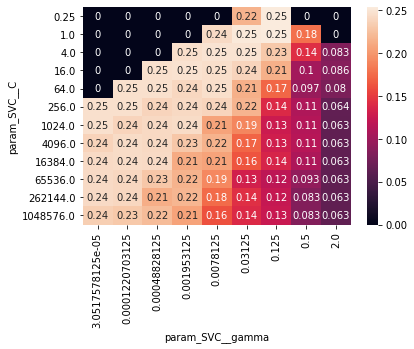

In [37]:
tune_model = Pipeline([
    ('Trans',transformer),
    ('SVC', SVC(class_weight={0:0.1,1:1}))
])

# Set the parameters
tuned_parameters = [{'SVC__gamma': [2**x for x in range(-15,2,2)],
                     'SVC__C' : [2**x for x in range(-2,21,2)]}]
GS1 = GridSearchCV(estimator=tune_model, param_grid=tuned_parameters, scoring=scoring, cv=kfold, n_jobs=-1)
GS1.fit(X_train, y_train)
result = pd.pivot_table(pd.DataFrame(GS1.cv_results_),values='mean_test_score',
                        columns='param_SVC__gamma',index='param_SVC__C')
sns.heatmap(result,annot=True)
print("the parameters {} are the best.".format(GS1.best_params_))

Finner Grid search

the parameters {'SVC__C': 0.25, 'SVC__gamma': 0.125} are the best.


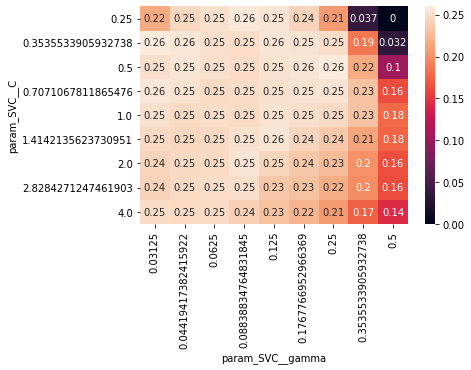

In [39]:
# Set the parameters
finner_parameters = [{'SVC__gamma': [2**x for x in np.arange(-5,-0.9,0.5)],
                     'SVC__C' : [2**x for x in np.arange(-2,2.1,0.5)]
                     }]
GS2 = GridSearchCV(estimator=tune_model, param_grid=finner_parameters, scoring=scoring, cv=kfold, n_jobs=-1)
GS2.fit(X_train, y_train)
result2 = pd.pivot_table(pd.DataFrame(GS2.cv_results_),values='mean_test_score',
                        columns='param_SVC__gamma',index='param_SVC__C')
sns.heatmap(result2,annot=True)
print("the parameters {} are the best.".format(GS1.best_params_))

Parameter chosen range:
- Kernel: linear
- C (penalty parameter): $$2^{-8} \to 2^{-3}$$

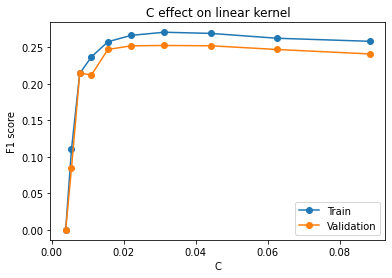

In [33]:
tune_model = Pipeline([
    ('Trans',transformer),
    ('SVC', SVC(kernel='linear',class_weight={0:0.1,1:1}))
])
train_result, val_result = [], []
tuned_C = [2**x for x in np.arange(-8,-3,0.5)]

# Set the parameters
for c in tuned_C:
    tune_model['SVC'].set_params(C=c)
    cv_results = cross_validate(tune_model, X_train, y_train, cv = kfold, scoring=scoring, return_train_score=True)
    train_result.append(cv_results['train_score'].mean())
    val_result.append(cv_results['test_score'].mean())
my_lineplot(tuned_C, [train_result,val_result],['Train','Validation'],'C','F1 score','C effect on linear kernel')

$$C=2^{-5}$$ is the best value for linear kernel
### Compare the result of linear kernel and RBF kernel with their tuned parameters

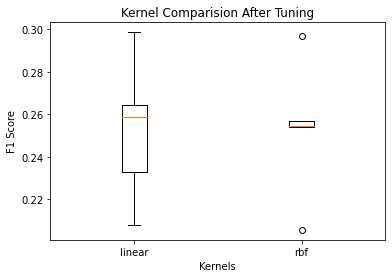

linear mean: 0.252446
rbf mean: 0.253570


In [47]:
results = {'linear':[], 'rbf':[]}
for kernel in results:
    kernel_model = Pipeline([('Trans',transformer),
                             ('SVC',SVC(kernel=kernel,class_weight={0:0.1,1:1}))
                             ])
    if kernel == 'linear':
        kernel_model['SVC'].set_params(C=2**-5)
    elif kernel == 'rbf':
        kernel_model['SVC'].set_params(C=0.5,gamma=0.125)
    cv_results = cross_val_score(kernel_model, X_train, y_train, cv=kfold, scoring=scoring)
    results[kernel].extend(cv_results)
my_boxplot(list(results.values()),list(results.keys()),"Kernels", "F1 Score", "Kernel Comparision After Tuning")
for name in results:
    print('%s mean: %f'%(name,np.array(results[name]).mean()))

## 4. Evaluation
Predict and evaluate the accuracy on test data

[[1335  269]
 [  23   59]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1604
           1       0.18      0.72      0.29        82

    accuracy                           0.83      1686
   macro avg       0.58      0.78      0.59      1686
weighted avg       0.94      0.83      0.87      1686



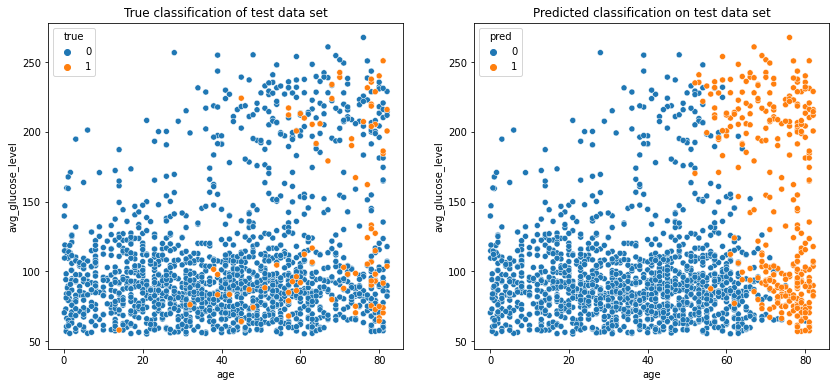

In [46]:
svc = Pipeline([('Trans', transformer),
                ('SVC',SVC(kernel='linear',C=2**-5,class_weight={0:0.1,1:1}))
                ])
svc.fit(X_train,y_train)

y_predict = svc.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
test_data = X_test.copy()
test_data['true'] = y_test
test_data['pred'] = y_predict
test_data.sort_values('true', inplace=True)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=test_data, x='age', y='avg_glucose_level', hue='true')
plt.title('True classification of test data set')

test_data.sort_values('pred', inplace=True)
plt.subplot(1, 2, 2)
sns.scatterplot(data=test_data, x='age', y='avg_glucose_level', hue='pred')
plt.title('Predicted classification on test data set')
plt.show()